# 6. Classification Task: Predicting What Papers Should Be Retracted

## Introduction


This Notebook performs our **main classification task**. It uses some of the most common classifier models (logistic regressor, XGBoost Classifier, and Random Forest Classifier) to **predict what papers are at risk of retraction**, and the most common vectorizers (Bag of Words and tf idf) to convert text data into numbers that our models can process. We will use our corpus of abstracts for both retracted and non-retracted papers to carve out both our train and test data sets for this task. 

The Notebook uses the corpus of abstracts that was generated in **Notebook 5**.


The **workflow** of the notebook is set up as follows:

- Input: **one .csv file** with abstract data for fraudulent papers, and **one .csv** file with abstract data for non-fraudulent papers.
- Output: **none**.

## Input / Output Parameters:

Input:

In [2]:

# File name for text data from fraudulent papers
#file_name_fraudulent = "cellbio_abstracts_non-retracted_text.csv"

file_name_fraudulent = "cellbio_abstracts_retracted_text.csv"

# File path for text data from fraudulent papers

file_path_fraudulent = "../data/text_data/" + file_name_fraudulent

# File name for text data from legitimate papers
#file_name_legit = "cellbio_abstracts_retracted_text.csv"

file_name_legit = "cellbio_abstracts_non-retracted_text.csv"

# File path for text data from legitimate papers

file_path_legit = "../data/text_data/" + file_name_legit 

# File path for country codes dictionary

file_path_country_codes = "../data/country_codes_dictionary.csv"

## Importing Required Libraries

Let us start by importing the required libraries to implement our task:

In [1]:

# Import required libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import json
import os

from scipy.stats import norm

import time
from function_definitions import seconds_to_hms



## Loading Abstracts for Retracted Papers


We will start by uploading our corpus of reconstructed abstracts from a .csv file. Let us start with retracted papers:

In [67]:

# Read reconstructed abstracts for retracted papers from .csv file
# Note that separator is "|"

df_fraudulent_abstracts = pd.read_csv(file_path_fraudulent, sep = "|" )

# Read country codes correspondences from .csv

df_country_codes = pd.read_csv(file_path_country_codes, encoding='latin-1')

# Display data frame

df_fraudulent_abstracts.head(1)


,abstract_text,target,doi,country,year,ret_flag
0,"""Abstract Hypoxia and sepsis are key concerns ...",1,10.1088_1748-605X_abd1b8,IN,2021,False



Retracted abstracts often include a statement indicating that the paper in question has been retracted. In our case, those were already marked with a "yes" in the "ret_flag" column, so we can simply remove them from our data frame:

In [83]:

# Filter away columns for which "ret_flag" is true

df_fraudulent_abstracts = df_fraudulent_abstracts[df_fraudulent_abstracts['ret_flag'] != True]

df_ret_flag = df_fraudulent_abstracts[df_fraudulent_abstracts['ret_flag'] = True]


SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (1493418479.py, line 5)

The abstract text that remains can now go into our corpus for retracted papers:

In [82]:

# Store column with reconstructed text into our list for the legit corpus

corpus_fraudulent = df_fraudulent_abstracts.abstract_text

# Visualize result

corpus_fraudulent

0       "Abstract Hypoxia and sepsis are key concerns ...
1       "Most ovarian cancers are diagnosed at advance...
2       "Purpose: Evidence indicates that the actin-bi...
3       "Papillary thyroid carcinoma (PTC) is the most...
4       "Other SectionsABSTRACTINTRODUCTIONRESULTSDISC...
                              ...                        
6631    "The present study investigated the effect of ...
6632    "Endothelin is a long-lasting potent vasoconst...
6633    "In the plant RNA interference (RNAi) pathway ...
6634    "Monocytes play an important role in inflammat...
6635    "Cytosolic phospholipase A(2)alpha (cPLA(2)alp...
Name: abstract_text, Length: 5897, dtype: object

## Loading Abstracts for Non-Retracted Papers

Let us now turn to our non-retracted papers. We start by loading the relevant abstract text into a data frame:

In [36]:

# Read reconstructed abstracts for non-retracted papers from .csv file
# Note that separator is "|"

df_legit_abstracts = pd.read_csv(file_path_legit, sep = "|" )

# Display data frame

df_legit_abstracts.head(1)



,abstract_text,target,doi,country,year,ret_flag
0,"""Targeting cancer stem cells is critical for s...",0,10.1186_s13045-018-0613-5,CN,2018,False



Although these papers were labelled as not retracted by OpenAlex, it will still be convenient to filter again potential occurrences of the word the word "retracted" etc. in the abstract:

In [59]:

# Filter away columns for which "ret_flag" is true

#df_legit_abstracts = df_legit_abstracts[df_legit_abstracts['ret_flag'] != True]

df_legit_abstracts = df_legit_abstracts[df_legit_abstracts['ret_flag']]

df_legit_abstracts

,abstract_text,target,doi,country,year,ret_flag
36,"""The case report aims to discuss the clinical ...",0,10.1097_md.0000000000010663,CN,2018,True
47,"""Keratocytes are fast-moving cells in which ad...",0,10.1371_journal.pbio.1001059,US,2011,True
629,"""We sought to evaluate the long-term efficacy ...",0,10.2337_dc05-2370,JP,2006,True
846,"""Turnover of focal adhesions allows cell retra...",0,10.1038_ncomms11692,US,2016,True
912,"""Accumulating evidence suggest that behavioral...",0,10.1016_j.pnpbp.2021.110456,MO,2022,True
2308,"""Article15 August 2001free access Regulation o...",0,10.1093_emboj_20.16.4370,GB,2001,True
2310,"""Contact inhibition ubiquitously exists in non...",0,10.1242_jcs.103267,US,2012,True
2438,"""Cellular locomotion is driven by repeated cyc...",0,10.1242_jcs.00792,IL,2003,True
2911,"""Migrasomes are newly discovered cell organell...",0,10.1038_s41467-023-36596-9,IL,2023,True
2981,"""Cell motility proceeds by cycles of edge prot...",0,10.1016_j.cell.2006.12.039,FR,2007,True


In [66]:
df_legit_abstracts.at[5972, "abstract_text"]

'"BackgroundManagement of bone cancer pain is difficult because of its complex mechanisms  which has a major impact on the quality of patients daily life. Recent studies have indicated that endoplasmic reticulum stress is involved in many neurological and inflammatory pathways associated with pain. However  the factors that contribute to endoplasmic reticulum stress and its causes in bone cancer pain are still unknown. In this study  we examined whether the endoplasmic reticulum stress response is involved in caspase signaling pathway-dependent apoptosis in neurons in the spinal dorsal horn of tumor-bearing rats and whether it thereby induces bone cancer pain. MethodsBone cancer pain was measured behaviorally by the paw withdrawal threshold. The expression levels of endoplasmic reticulum stress markers  namely  immunoglobulin-binding protein/glucose-regulated protein 78 (BIP/GRP78)  activating transcription factor-6 (ATF6)  phosphorylated inositol-requiring enzyme-1 (p-IRE1)  phosphory

In [37]:

# Store column with reconstructed text into our list for the legit corpus

corpus_legit = df_legit_abstracts.abstract_text



Finally, we can put the two lists with reconstructed abstracts together to obtain our corpus:

In [38]:

# Create corpus

corpus = []
corpus.extend(corpus_fraudulent) # Note that we are adding our fraudulent papers first
corpus.extend(corpus_legit)

## Data Preprocessing and Test-Train Split


We can now use the "target" column of our data frame to define our target variable and our features, in case we have them:

In [69]:

# Create data frame with all abstracts

df_all_abstracts = pd.concat([df_legit_abstracts, df_fraudulent_abstracts], ignore_index=True)

# Definte target and features

X = df_all_abstracts["abstract_text"]
y = df_all_abstracts["target"]

We are now ready to split our data set into a train and test portion:

In [70]:

# Split data into train and text sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization with CountVectorizer()


We can now go ahead and vectorize our whole corpus using the bag of words method. First we generate our vocabulary by applyzing a Count Vectorizer to our train data set:

In [71]:

# Instantiate CountVectorizer 

vectorizer = CountVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create bag of words vectors

X_train_vec = vectorizer.fit_transform(X_train)

# Obtain vocabulary for corpus

print("Vocabulary:")
print(vectorizer.get_feature_names_out())

# Print bag of words vectors for each document in corpus

print("\nBag of Words vectors:")
print(X_train_vec.toarray())

Vocabulary:
['00' '000' '0000' ... 'zymography' 'zymolyase' 'zyxin']

Bag of Words vectors:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


- And now we use that vocabulary to vectorize our test data set:

In [72]:

# Vectorize test data set by using our vectorizer

X_test_vec = vectorizer.transform(X_test)

## Vectorization with TF-IDF


We can also try and vectorize our corpus using TF-IDF instead. Again, we start by applying the vectorizer to our train data set:

In [73]:

# Instantiate CountVectorizer 

tfidf = TfidfVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create bag of words vectors

X_train_tfidf = tfidf.fit_transform(X_train)

# Obtain vocabulary for corpus

print("Vocabulary:")
print(tfidf.get_feature_names_out())

# Print bag of words vectors for each document in corpus

print("\nTF-IDF vectors:")
print(X_train_tfidf.toarray())

Vocabulary:
['00' '000' '0000' ... 'zymography' 'zymolyase' 'zyxin']

TF-IDF vectors:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- And we then use the vocabulary generated from the train data set to vectorize out test data set:

In [74]:

# Vectorize test data set using vocabulary from train

X_test_tfidf = tfidf.transform(X_test)

## K-Best Analysis 

In [75]:

# Instantiate select k best 

k_best = SelectKBest(score_func=f_classif, k=20)  

# Fit select k best to training data 

X_train_selected_vec = k_best.fit_transform(X_train_vec, y_train)

# Get indices of k most salient feature

selected_feature_indices = k_best.get_support(indices=True)

# Obtain words corresponding to each index from vectorizer

features_list = vectorizer.get_feature_names_out()


# Obtain words corresponding to most salient features from index

selected_feature_names = [features_list[i] for i in selected_feature_indices]

# Visualize most salient words

selected_feature_names

# Obtain scores of selected features
selected_feature_scores = k_best.scores_[selected_feature_indices]

# Pair feature names with their corresponding scores
feature_scores = list(zip(selected_feature_names, selected_feature_scores))

# Print feature names and scores
for feature_name, score in feature_scores:
    print(f"Feature: {feature_name}, Score: {score}")

Feature: adhesions, Score: 865.903804745295
Feature: bending, Score: 323.99224142046796
Feature: confluent, Score: 455.1971622095852
Feature: danio, Score: 442.4174786084567
Feature: edge, Score: 1078.4325451351924
Feature: fluctuates, Score: 442.4174786084567
Feature: focal, Score: 343.35908501816937
Feature: lamella, Score: 318.28595583342207
Feature: lamellipodial, Score: 348.1317864459987
Feature: lamellipodium, Score: 440.99474328283003
Feature: polymerization, Score: 330.4366347685043
Feature: profilin, Score: 442.4174786084567
Feature: protruding, Score: 442.4174786084567
Feature: protrusion, Score: 1302.209937036212
Feature: rear, Score: 501.34450228194885
Feature: rerio, Score: 442.4174786084567
Feature: trailing, Score: 442.4174786084567
Feature: upward, Score: 323.99224142046796
Feature: yonezawa, Score: 442.4174786084567
Feature: zebrafish, Score: 455.05906529623223


In [76]:

# Create a boolean mask to filter rows where "assay" is present in the "abstract_text" column
mask = df_all_abstracts["abstract_text"].str.contains("western")

# Apply the mask to filter rows
filtered_rows = df_all_abstracts[mask]

# Display the filtered rows
print(filtered_rows)

                                          abstract_text  target  \
5     "Article15 August 2001free access Regulation o...       0   
10    "Background: Centella asiatica (L.) Urb. is a ...       0   
21    "Acupuncture has been used to treat myofascial...       0   
28    "BackgroundManagement of bone cancer pain is d...       0   
45    "Cucurbitacin E (CuE)  a potent member of trit...       1   
...                                                 ...     ...   
6139  "Prostate cancer (PCA) is the second most freq...       1   
6254  "Abstract Background Systemic lupus erythemato...       1   
6480  "Medullary thyroid carcinoma (MTC) is a rare t...       1   
6484  "Hepatocellular carcinoma (HCC) is one of the ...       1   
6489  "Abstract Background Distal esophageal adenoca...       1   

                              doi  country  year  ret_flag  
5        10.1093_emboj_20.16.4370       GB  2001      True  
10      10.18632_oncotarget.17654       CN  2017      True  
21    10.113

In [77]:
df_all_abstracts.iloc[9].abstract_text

'"Cell motility proceeds by cycles of edge protrusion  adhesion  and retraction. Whether these functions are coordinated by biochemical or biomechanical processes is unknown. We find that myosin II pulls the rear of the lamellipodial actin network  causing upward bending  edge retraction  and initiation of new adhesion sites. The network then separates from the edge and condenses over the myosin. Protrusion resumes as lamellipodial actin regenerates from the front and extends rearward until it reaches newly assembled myosin  initiating the next cycle. Upward bending  observed by evanescence and electron microscopy  results in ruffle formation when adhesion strength is low. Correlative fluorescence and electron microscopy shows that the regenerating lamellipodium forms a cohesive  separable layer of actin above the lamellum. Thus  actin polymerization periodically builds a mechanical link  the lamellipodium  connecting myosin motors with the initiation of adhesion sites  suggesting that

## Classification with Logistic Regression

- We can now instantiate our model, fit it to our train data, and use it to obtain predictions for our test data:

In [78]:


# Instantiate logistic regressor

log_reg = LogisticRegression(max_iter = 200)

# Store start time of loop execution

start_time = time.time()

# Fit logistic regressor to our train data set

#log_reg.fit(X_train_vec, y_train)

log_reg.fit(X_train_tfidf, y_train)

# Use logistic regressor to obtain predictions for test data set

#y_pred = log_reg.predict(X_test_vec)

y_pred = log_reg.predict(X_test_tfidf)

# And for train data set

#y_pred_train = log_reg.predict(X_train_vec)

y_pred_train = log_reg.predict(X_train_tfidf)

# Calculate elapsed time for for training model

elapsed_time = time.time() - start_time

# Convert time to hours, minutes, and seconds

elapsed_hours, elapsed_minutes, elapsed_seconds = seconds_to_hms(elapsed_time)

# Print message with elapsed time

print(f"Time taken to train the model: {elapsed_hours}h, {elapsed_minutes}m, {elapsed_seconds}s. \n")


Time taken to train the model: 0.0h, 0.0m, 0.20913195610046387s. 




- Finally let us see how well our model is performing by obtaining some evaluations metrics for it:

In [79]:

# Obtain accuracy score and other evaluation metrics

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

report_test = classification_report(y_test, y_pred)

report_train = classification_report(y_train, y_pred_train)

# Print scores

print("Accuracy on train data set:", accuracy_train)
print("Accuracy on test data set:", round(accuracy_test,2))

print("Classification Report for Train:\n", report_train)

print("Classification Report for Test:\n", report_test)

Accuracy on train data set: 0.9951283492598838
Accuracy on test data set: 0.99
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       1.00      1.00      1.00      5311

    accuracy                           1.00      5337
   macro avg       0.50      0.50      0.50      5337
weighted avg       0.99      1.00      0.99      5337

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.99      1.00      1.00      1326

    accuracy                           0.99      1335
   macro avg       0.50      0.50      0.50      1335
weighted avg       0.99      0.99      0.99      1335



/Users/pdolano/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pdolano/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pdolano/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

- And the confusion matrix:

In [80]:

# Obtain confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred)

print("Confusion Matrix for Log Reg:\n", conf_matrix_log_reg)


Confusion Matrix for Log Reg:
 [[   0    9]
 [   0 1326]]



- Let us also find out what the values of the coefficients associated to the different features are:

In [51]:
# Obtain coefficients for logistic regressor

coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_

# Obtain feature names from vocabulary

feature_names = vectorizer.get_feature_names_out()

# Pair each feature with its coefficient

coefficients_with_features = list(zip(feature_names, coefficients))

# Sort coefficients based on absolute values

sorted_coefficients = sorted(coefficients_with_features, key=lambda x: abs(x[1]), reverse=True)

# Print the top 10 coefficients along with their corresponding features

print("Top 20 coefficients with largest absolute magnitude:")
for i, (feature, coefficient) in enumerate(sorted_coefficients[:15], start=1):
    print(f"{i}. Feature: {feature}, Coefficient: {coefficient}")
    

Top 20 coefficients with largest absolute magnitude:
1. Feature: yap, Coefficient: -6.8435230095658355
2. Feature: mir, Coefficient: 6.057638135727397
3. Feature: hippo, Coefficient: -5.180872331584496
4. Feature: zebrafish, Coefficient: -4.88350717479392
5. Feature: er, Coefficient: -4.719702757674965
6. Feature: stress, Coefficient: -4.482924551235056
7. Feature: yap1, Coefficient: -4.295989069811512
8. Feature: taurine, Coefficient: -4.019882203791222
9. Feature: vitiligo, Coefficient: -3.8782385859594584
10. Feature: tyrosinase, Coefficient: -3.776827059729754
11. Feature: grp78, Coefficient: -3.403020808878587
12. Feature: species, Coefficient: -3.379574247727655
13. Feature: taz, Coefficient: -3.263241445567326
14. Feature: mechanical, Coefficient: -3.2518773139810087
15. Feature: calpain, Coefficient: -3.2501269631555525


- Let us create a word cloud:

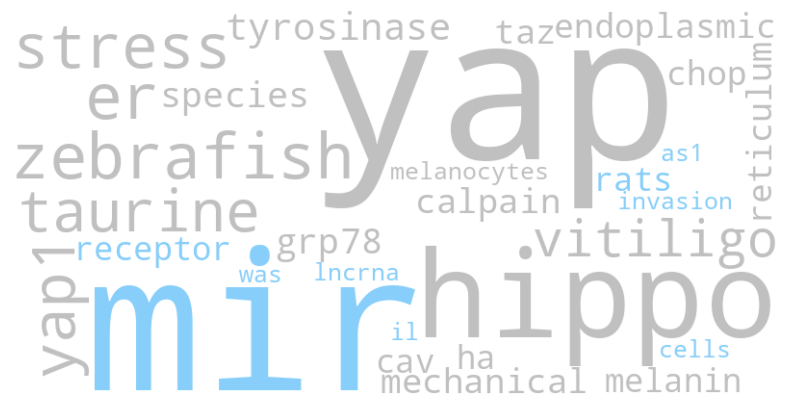

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sort coefficients by absolute value
sorted_coefficients = sorted(sorted_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Select the top 30 words
top_words = sorted_coefficients[:30]

# Separate words with positive and negative coefficients
positive_words = [word for word, coeff in top_words if coeff > 0]
negative_words = [word for word, coeff in top_words if coeff < 0]

# Generate word cloud with custom color function
def fixed_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in positive_words:
        # Set color to light blue for positive coefficients
        return "rgb(135, 206, 250)"  # Light blue color
    elif word in negative_words:
        # Set color to light grey for negative coefficients
        return "rgb(192, 192, 192)"  # Light grey color
    else:
        # Default color for neutral words
        return "rgb(128, 128, 128)"  # Default grey color

# Convert top_words into a dictionary
word_freq_dict = {word: abs(coeff) for word, coeff in top_words}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=fixed_color_func)
wordcloud.generate_from_frequencies(word_freq_dict)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


- Let us generate a cloud of words for these results:

## Classification with XGBoost

- Let us start by instantiating our model:

In [25]:
xgboost = XGBClassifier()

- And by fitting it to our vectorized train data set:

In [26]:
xgboost.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- We can now go on to make predictions with our trained model:

In [27]:

# Predictions for the test data set

y_pred_xgb = xgboost.predict(X_test_tfidf)

# And for train data set

y_pred_train_xgb = xgboost.predict(X_train_tfidf)


- Let us now and see how are model performs

In [28]:

# Obtain accuracy score and other evaluation metrics

accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

report_test_xgb = classification_report(y_test, y_pred_xgb)

report_train_xgb = classification_report(y_train, y_pred_train_xgb)

# Print scores

print("Accuracy on train data set (XGB Classifier):", accuracy_train_xgb)
print("Accuracy on test data set (XGB Classifier):", round(accuracy_test_xgb,2))

print("Classification Report for Train (XGB Classifier):\n", report_train_xgb)

print("Classification Report for Test (XGB Classifier):\n", report_test_xgb)

Accuracy on train data set (XGB Classifier): 0.9730332899386275
Accuracy on test data set (XGB Classifier): 0.89
Classification Report for Train (XGB Classifier):
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      5443
           1       0.97      0.98      0.97      5311

    accuracy                           0.97     10754
   macro avg       0.97      0.97      0.97     10754
weighted avg       0.97      0.97      0.97     10754

Classification Report for Test (XGB Classifier):
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      1363
           1       0.88      0.89      0.89      1326

    accuracy                           0.89      2689
   macro avg       0.89      0.89      0.89      2689
weighted avg       0.89      0.89      0.89      2689



- Same for XGBoost

In [29]:

# Obtain confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Confusion Matrix XGB Classifier:\n", conf_matrix_xgb)


Confusion Matrix XGB Classifier:
 [[1204  159]
 [ 147 1179]]


## Classification with Random Forest

In [30]:

# Configuration of the RandomForest Classifier
clf = RandomForestClassifier(
    n_estimators=8000,
    max_depth=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Start timing for fitting the model
start_time = time.time()
clf.fit(X_train_tfidf, y_train)
end_time = time.time()
fit_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(fit_time)
print(f"Training completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Start timing for making predictions
start_time = time.time()
y_pred_rf = clf.predict(X_test_tfidf)
y_pred_train_rf = clf.predict(X_train_tfidf)
end_time = time.time()
predict_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(predict_time)
print(f"Prediction completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)


Training completed in: 0.0 hours, 0.0 minutes, and 35.00 seconds
Prediction completed in: 0.0 hours, 0.0 minutes, and 5.29 seconds
Accuracy: 0.7947192264782447


In [31]:
# Get feature importances from the trained model
importances = clf.feature_importances_

# Get feature names from the vectorizer
feature_names = tfidf.get_feature_names_out()

# Define the number of top features you want to display
K = 20

# Get the indices of the K most important features in descending order of importance
indices = importances.argsort()[-K:][::-1]

# Display the top K important features with their names and importance scores
top_features = [(feature_names[i], importances[i]) for i in indices]
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

mir: 0.0123
was: 0.0085
endoplasmic: 0.0084
expression: 0.0080
reticulum: 0.0076
assay: 0.0066
is: 0.0065
er: 0.0063
western: 0.0062
are: 0.0059
retracted: 0.0058
hippo: 0.0057
luciferase: 0.0055
invasion: 0.0055
yap: 0.0054
stress: 0.0051
article: 0.0050
here: 0.0049
we: 0.0047
microrna: 0.0046


In [32]:

# Define function to fit & rpedict random forest


def train_and_log_rf(n_estimators, max_depth, train_data, train_labels, test_data, test_labels):
    # Configuration of the RandomForest Classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    # Start timing for fitting the model
    start_time = time.time()
    clf.fit(train_data, train_labels)
    fit_time = time.time() - start_time  # Time in seconds
    print(f"Training Time: {fit_time:.2f} seconds")

    # Start timing for making predictions
    start_time = time.time()
    y_pred = clf.predict(test_data)
    predict_time = time.time() - start_time  # Time in seconds
    print(f"Prediction Time: {predict_time:.2f} seconds")

    # Evaluate the model
    accuracy = accuracy_score(test_labels, y_pred)
    print("Accuracy:", accuracy)

    # Prepare data for logging
    log_data = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'training_time': f"{fit_time:.2f} seconds",
        'prediction_time': f"{predict_time:.2f} seconds",
        'accuracy': accuracy
    }
    log_df = pd.DataFrame([log_data])

    # Define log file path
    log_file_path = '../data/model_logs/model_performance_log.csv'

    # Check if the directory exists, if not, create it
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

    # Check if file exists, append if it does, otherwise write a new file
    if os.path.isfile(log_file_path):
        log_df.to_csv(log_file_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_file_path, mode='w', header=True, index=False)

    # Return the model, predictions, and accuracy
    return clf, y_pred, accuracy



In [33]:
# Define number of trees & tree depth and instatiate fitting the model and making the predicitons

num_trees = 4000
tree_depth = 40

clf, y_pred_rf, accuracy_rf = train_and_log_rf(num_trees, tree_depth, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training Time: 49.98 seconds
Prediction Time: 0.84 seconds
Accuracy: 0.8136853849014504


In [34]:

# Calculate accuracy just for train

accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
print(f"Accuracy: {accuracy_train_rf:.2f}")

# Generate and print classification report for train

report_train_rf = classification_report(y_train, y_pred_train_rf)
print("Classification Report:")
print(report_train_rf)

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5443
           1       0.94      0.86      0.90      5311

    accuracy                           0.90     10754
   macro avg       0.91      0.90      0.90     10754
weighted avg       0.91      0.90      0.90     10754



In [35]:

# Calculate accuracy just for test

accuracy_test_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_test_rf:.2f}")

# Generate and print classification test

report_test_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report_test_rf)

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1363
           1       0.85      0.76      0.80      1326

    accuracy                           0.81      2689
   macro avg       0.82      0.81      0.81      2689
weighted avg       0.82      0.81      0.81      2689



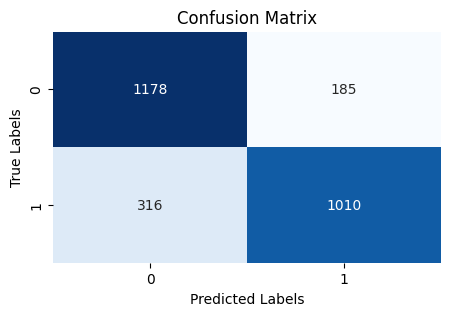

In [36]:
# Assign
cm = confusion_matrix(y_test, y_pred_rf)


# Plotting the heatmap
plt.figure(figsize=(5, 3))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'fmt' is a string format code
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ROC Curve for all three Models 


- Let us also obtain ROC score and visualize the ROC curve for our regressor:

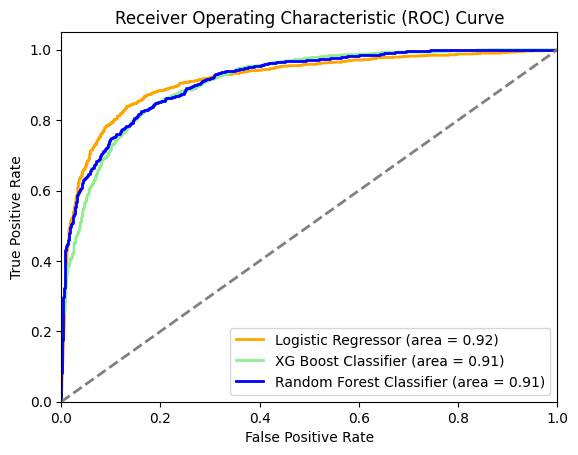

In [37]:

# Obtain predicted probabilities for positive class (Log Reg)

y_pred_proba = log_reg.predict_proba(X_test_vec)[:, 1]

# Obtain predicted probabilities for positive class (XGB classifier)

y_pred_proba_xgb = xgboost.predict_proba(X_test_vec)[:, 1]

# Obtain predicted probabilities for positive class (random forest classifier)

y_pred_proba_rf = clf.predict_proba(X_test_vec)[:, 1]

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Compute Area Under the Curve (AUC)

roc_auc = auc(fpr, tpr)

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

roc_auc_rf = auc(fpr_rf, tpr_rf)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='Logistic Regressor (area = %0.2f)' % roc_auc)
plt.plot(fpr_xgb, tpr_xgb, color='lightgreen', lw=2, label='XG Boost Classifier (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest Classifier (area = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## Model Performance for Different Countries


-Finally, let us also make sure that our model gives comparable predictions for papers from different years and countries. Let us start with China:

In [38]:

# Obtain only abstracts for papers from China and store them in data frame

df_ch = df_all_abstracts[df_all_abstracts["country"] == "CN"]

# Visualize shape of filtered array

print(df_ch.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_ch_tfidf = tfidf.transform(df_ch["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_ch = log_reg.predict(X_ch_tfidf)

(8034, 7)


In [39]:

# Obtain number of papers flagged as fraudulent

y_pred_ch.sum()

4197

In [40]:

# Obtain number of papers that we tested in total

len(y_pred_ch)

8034

In [41]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_china = y_pred_ch.sum() / len(y_pred_ch) * 100

# Visualize result

per_fraud_china 

52.2404779686333

In [42]:
df_ch_fraud = df_ch[df_ch["target"] == 1]

In [43]:
df_ch_fraud.shape

(3952, 7)

In [44]:
df_ch_fraud.shape[0] / df_ch.shape[0] * 100

49.19093851132686

- Let us now repeat the same steps for the US:

In [45]:

# Obtain only abstracts for papers from China and store them in data frame

df_us = df_all_abstracts[df_all_abstracts["country"] == "US"]

# Visualize shape of filtered array

print(df_us.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_us_tfidf = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us_tfidf)

(2211, 7)


In [46]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_us = y_pred_us.sum() / len(y_pred_us) * 100

# Visualize result

per_fraud_us

38.44414292175487

In [47]:
df_us_fraud = df_us[df_us["target"] == 1]

In [48]:
df_us_fraud.shape[0] / df_us.shape[0] * 100

42.06241519674355


- It will be easier to simply write a function that performs all these operations for future use:

In [49]:

def model_tester_country(country_code, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["country"] == country_code]

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)
    
    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {country_code} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {country_code} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

- Let us test it to make sure it works OK:

In [50]:

# Calculate percentage of papers flagged for US

model_tester_country("US", df_all_abstracts, tfidf, log_reg)

(38.44414292175487, 42.06241519674355, 850, 930)

In [51]:

# Now for China

model_tester_country("CN", df_all_abstracts, tfidf, log_reg)

(52.2404779686333, 49.19093851132686, 4197, 3952)

In [52]:

# UK

model_tester_country("GB", df_all_abstracts, tfidf, log_reg)

(37.03703703703704, 42.592592592592595, 80, 92)

In [53]:

# India

model_tester_country("IN", df_all_abstracts, tfidf, log_reg)

(50.32258064516129, 54.83870967741935, 156, 170)

In [54]:

# Iran

model_tester_country("IR", df_all_abstracts, tfidf, log_reg)

(52.63157894736842, 53.216374269005854, 90, 91)

In [55]:
# France

model_tester_country("AU", df_all_abstracts, tfidf, log_reg)

(31.666666666666664, 36.666666666666664, 19, 22)

- Let us run a similar quality test for our year breakdown:

In [56]:

def model_tester_year(year, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["year"] == year]

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

In [57]:
model_tester_year(2020, df_all_abstracts, tfidf, log_reg)

(50.382165605095544, 46.87898089171975, 791, 736)

In [58]:
model_tester_year(2019, df_all_abstracts, tfidf, log_reg)

(51.41635489043293, 47.247461250668096, 962, 884)

In [59]:
model_tester_year(2009, df_all_abstracts, tfidf, log_reg)

(45.90163934426229, 52.131147540983605, 140, 159)


- Finally, let us create a function that allows us to run an analysis for both a country and a year of our choice:

In [60]:

def model_tester_year_country(year, country, df, vectorizer, model):
    
    # Obtain only abstracts for papers from a given bucket and store them in data frame

    df_filtered = df[(df["year"] == year) & (df["country"] == country)]

    # Vectorize text for those papers using our vectorizer

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with our model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {year} and {country} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {year} and {country} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
    

In [61]:

model_tester_year_country(2017, "CN", df_all_abstracts, tfidf, log_reg)

(52.532391048292105, 49.94110718492344, 446, 424)

In [62]:

model_tester_year_country(2021, "US", df_all_abstracts, tfidf, log_reg)

(32.5, 32.5, 13, 13)

In [63]:

model_tester_year_country(2018, "IR", df_all_abstracts, tfidf, log_reg)

(50.0, 50.0, 9, 9)

- Let us try a more systematic comparison for all countries:

In [64]:

countries = df_all_abstracts["country"].unique()
results = []
difference_percentage = []
difference_total = []

for country in countries:
    country_results = model_tester_country(country, df_all_abstracts, tfidf, log_reg)
    results.append(country_results)
    difference_percentage.append(country_results[0] - country_results[1])
    difference_total.append(country_results[2] - country_results[3])



In [65]:


df_differences = pd.DataFrame({"country": countries, "percentage_difference": difference_percentage, "total_difference": difference_total})

In [66]:

df_differences = df_differences[df_differences["total_difference"] != 0]

<Axes: xlabel='country'>

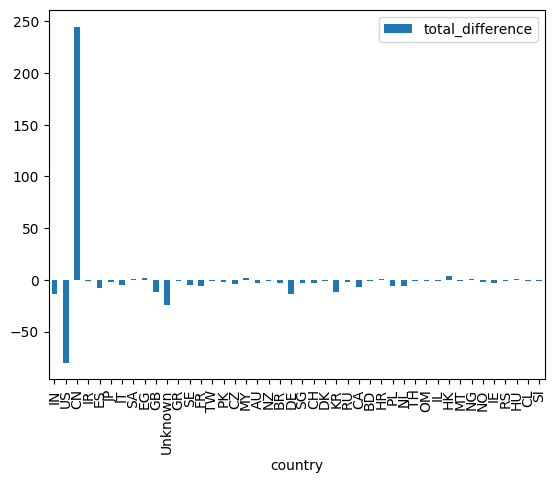

In [67]:

df_differences.plot.bar(x="country", y="total_difference")


In [68]:

# Obtain size of data frame to decide how to filter top entires

df_differences.shape

(44, 3)

In [69]:

# Filter data frame to obtain countries with most papers in absolute number only 

df_differences_filtered = df_differences.head(27)

<Axes: xlabel='country'>

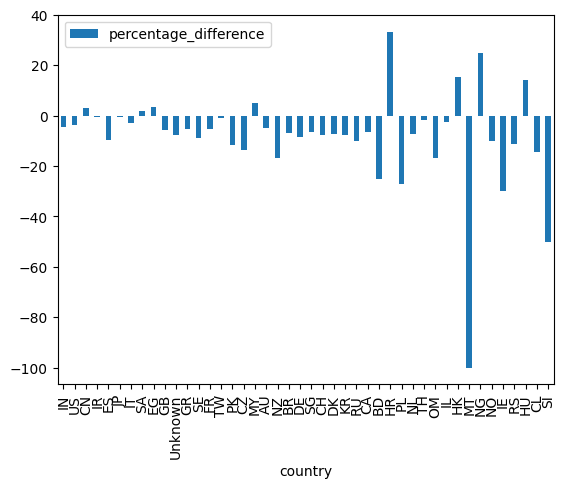

In [70]:

# Make normal plot

df_differences.plot.bar(x="country", y="percentage_difference")


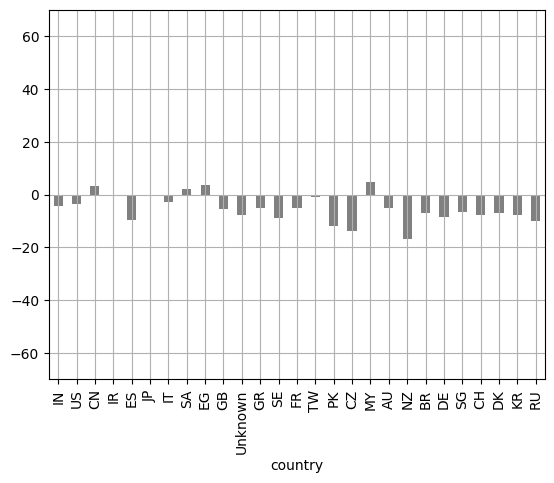

In [71]:

# Make plot for filtered data frame

ax = df_differences_filtered.plot.bar(x="country", y="percentage_difference", color='grey', legend=False)

# Set the y axis to -50 and 50 percentage points

ax.set_ylim(-70, 70)

# Add grid

ax.grid(True)

# Display plot

plt.show()


- And now for all years:

In [72]:

year_results = model_tester_year(2020, df_all_abstracts, tfidf, log_reg)


In [73]:
years = df_all_abstracts["year"].unique()
results_year = []
difference_percentage_year = []
difference_total_year = []


    
for year in years:
    year_results = model_tester_year(year, df_all_abstracts, tfidf, log_reg)
    results_year.append(year_results)
    difference_percentage_year.append(year_results[0] - year_results[1])
    difference_total_year.append(year_results[2] - year_results[3])



In [74]:
df_differences_year = pd.DataFrame({"year": years, "percentage_difference": difference_percentage_year, "total_difference": difference_total_year})

In [75]:
df_differences_year.head(5)

,year,percentage_difference,total_difference
0,2021,1.038062,9
1,2009,-6.229508,-19
2,2020,3.503185,55
3,2022,-0.416667,-3
4,2019,4.168894,78


<Axes: xlabel='year'>

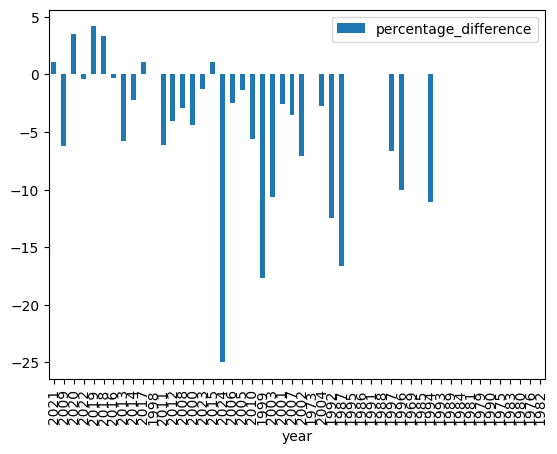

In [76]:
df_differences_year.plot.bar(x="year", y="percentage_difference")


<Axes: xlabel='year'>

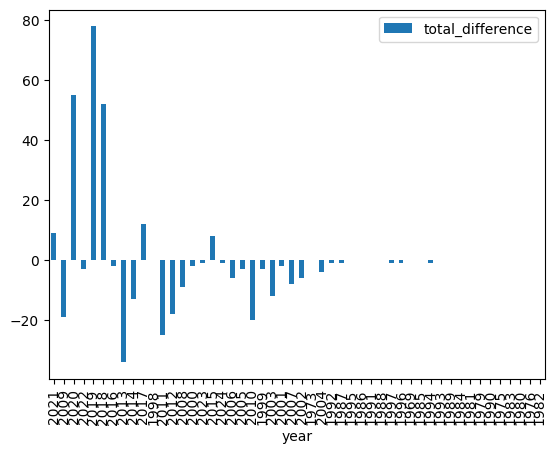

In [77]:

df_differences_year.plot.bar(x="year", y="total_difference")


-Let us get some scores and performance metrics per year and country too. First we'll try China:


In [78]:

df_china = df_all_abstracts[df_all_abstracts["country"] == "CN"]

# Vectorize text for those papers using TF-IDF vectorization

X_china = tfidf.transform(df_china["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_china = log_reg.predict(X_china)
    

In [79]:
y_china = df_china["target"]

report_test = classification_report(y_china, y_pred_china)

print("Classification Report for China:\n", report_test)

Classification Report for China:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      4082
           1       0.91      0.97      0.94      3952

    accuracy                           0.94      8034
   macro avg       0.94      0.94      0.94      8034
weighted avg       0.94      0.94      0.94      8034



In [80]:
conf_matrix_china = confusion_matrix(y_china, y_pred_china)

conf_matrix_china

array([[3704,  378],
       [ 133, 3819]])

- And then the US:

In [81]:

df_us = df_all_abstracts[df_all_abstracts["country"] == "US"]

# Vectorize text for those papers using TF-IDF vectorization

X_us = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us)
    

In [82]:
y_us = df_us["target"]

report_test_us = classification_report(y_us, y_pred_us)

print("Classification Report for the USA:\n", report_test_us)

Classification Report for the USA:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1281
           1       0.97      0.89      0.93       930

    accuracy                           0.94      2211
   macro avg       0.95      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211



In [83]:
conf_matrix_us = confusion_matrix(y_us, y_pred_us)

conf_matrix_us

array([[1258,   23],
       [ 103,  827]])